# Working with multiple stocks

### Load Stock Data

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
# Define a date range
dates = pd.date_range('2017-01-01', '2017-07-31')

# Choose stock symbols to read
symbols = ['googl', 'ibm', 'gld']

df = pd.DataFrame(index=dates)

In [3]:
# Fill dataframe with stock data (close) for given symbols 

if 'spy' not in symbols:  # add SPY for reference, if absent
    symbols.insert(0, 'spy')

for sym in symbols:
    df_temp = pd.read_csv("data/{}.csv".format(sym), index_col='Date', parse_dates=True, 
                          usecols=['Date', 'Close'], na_values=['nan'])
    df_temp = df_temp.rename(columns = {'Close': sym})
    df = df.join(df_temp)
    if sym == 'spy': # drop dates SPY did not trade
        df = df.dropna(subset=["spy"])     

df.head()

,spy,googl,ibm,gld
2017-01-03,225.24,808.01,167.19,110.47
2017-01-04,226.58,807.77,169.26,110.86
2017-01-05,226.40,813.02,168.70,112.58
2017-01-06,227.21,825.21,169.53,111.75
2017-01-09,226.46,827.18,167.65,112.67


In [4]:
# selection
df.loc['2017-07-12':'2017-07-15',['googl','ibm']]

,googl,ibm
2017-07-12,967.66,153.70
2017-07-13,968.85,153.63
2017-07-14,976.91,154.24


### Fill missing values

In [5]:
# Forward and backward fill code
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

### Visualize data

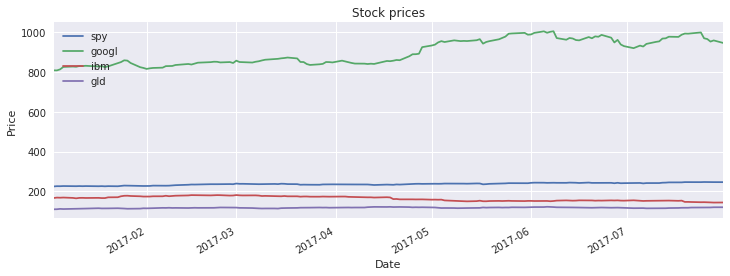

In [6]:
# plot stock prices
def plot_stock(data, title="Stock prices", label=""):    
    ax = data.plot(title=title, label=label, figsize=(12,4))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')

plot_stock(df)

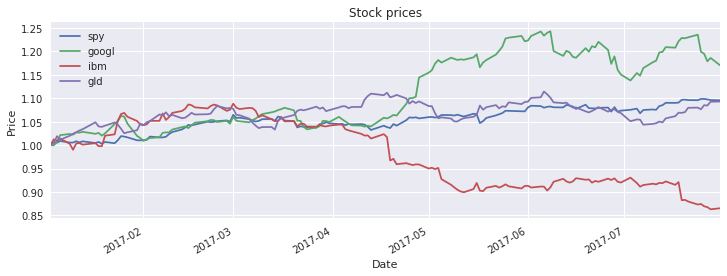

In [7]:
# normalize data based on fist row
normalized_df = df / df.iloc[0]
plot_stock(normalized_df)

### Statistics

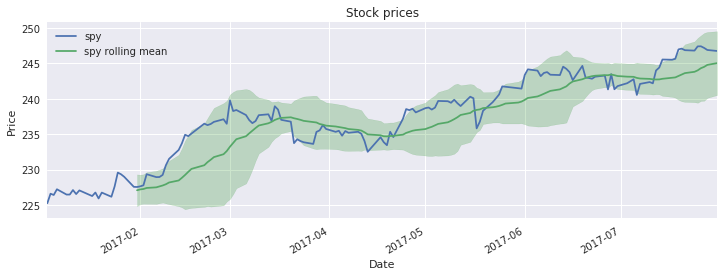

In [8]:
# Rolling window
rolling_spy = df['spy'].rolling(window=20, center=False)
rm_spy = rolling_spy.mean()
rstd_spy = rolling_spy.std()

plot_stock(df['spy'], label='spy')
plot_stock(rm_spy, label='spy rolling mean')
plt.fill_between(rm_spy.index, rm_spy - 2 * rstd_spy, rm_spy + 2 * rstd_spy, color='g', alpha=0.2)

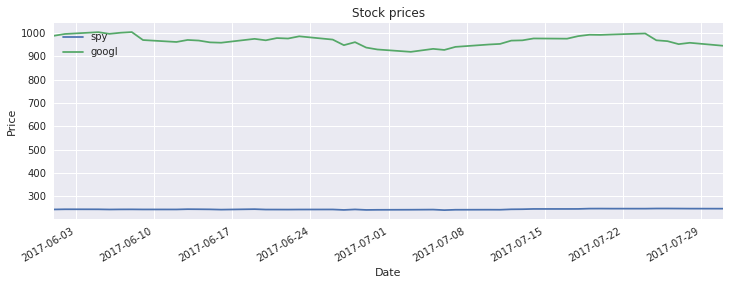

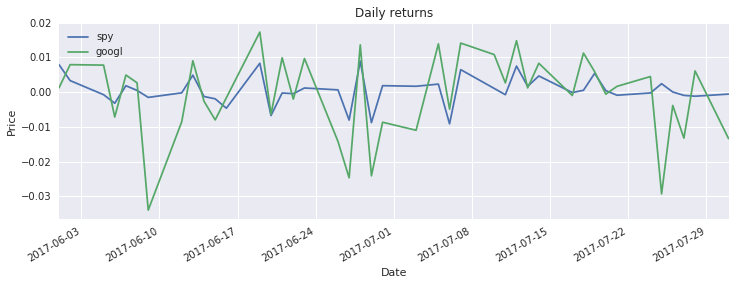

In [9]:
# Daily returns

daily_returns = (df/df.shift(1)) - 1
daily_returns.iloc[0,:] = 0
plot_stock(df.loc['2017-06-01':'2017-07-31',['spy','googl']])
plot_stock(daily_returns.loc['2017-06-01':'2017-07-31',['spy','googl']], title='Daily returns')

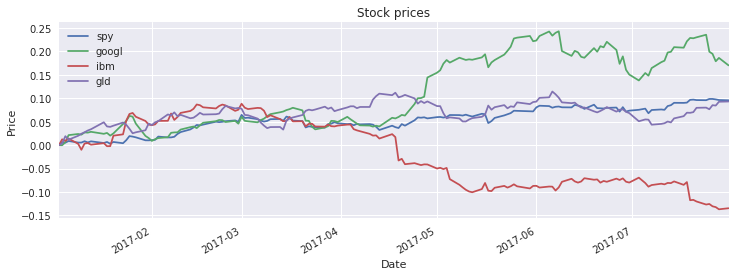

In [10]:
# Cumulative returns
cumulative_df = normalized_df - 1
plot_stock(cumulative_df)

mean = 0.0006
std = 0.0044
kurtosis = 2.3520


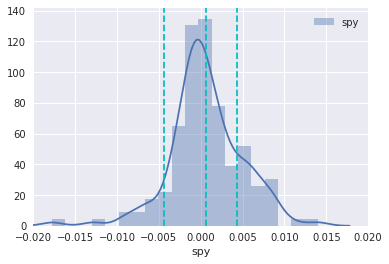

In [11]:
# Histograms

mean = daily_returns['spy'].mean()
std = daily_returns['spy'].std()
kurtosis = daily_returns['spy'].kurtosis()

sns.distplot(daily_returns['spy'], label='spy')
plt.xlim(-0.02, 0.02)
plt.legend()

plt.axvline(mean, color='c', linestyle='dashed')
plt.axvline(-std, color='c', linestyle='dashed')
plt.axvline(std, color='c', linestyle='dashed')

print("mean = {:.4f}".format(mean))
print("std = {:.4f}".format(std))
print("kurtosis = {:.4f}".format(kurtosis))

Kurtosis: 
spy      2.352037
googl    2.861418
ibm      8.113349
gld      0.389129
dtype: float64


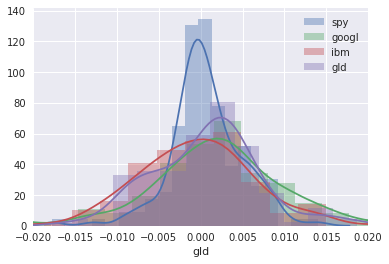

In [12]:
for sym in symbols:
    sns.distplot(daily_returns[sym], label=sym)
plt.xlim(-0.02, 0.02)
plt.legend()

print("Kurtosis: \n{}".format( daily_returns.kurtosis()))

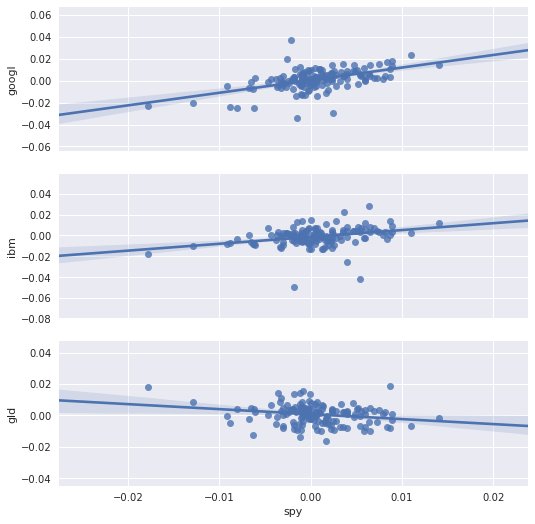

In [13]:
# Scatter plots
sns.pairplot(daily_returns,  x_vars='spy', y_vars=['googl','ibm','gld'], kind='reg', aspect=3)

In [14]:
alpha = {}
beta = {}
for sym in ['googl','ibm','gld']:
    beta[sym], alpha[sym] = np.polyfit(daily_returns['spy'], daily_returns[sym],1)
    print("{}:\talpha={:.4f}\tbeta={:.4f}".format(sym, alpha[sym], beta[sym]))
    
print("\n Correlation coefficient \n {}".format(daily_returns.corr(method='pearson')))

googl:	alpha=0.0004	beta=1.1486
ibm:	alpha=-0.0014	beta=0.6594
gld:	alpha=0.0008	beta=-0.3174

 Correlation coefficient 
             spy     googl       ibm       gld
spy    1.000000  0.520415  0.319040 -0.220513
googl  0.520415  1.000000  0.103331 -0.057879
ibm    0.319040  0.103331  1.000000 -0.056658
gld   -0.220513 -0.057879 -0.056658  1.000000


### Portfolio Statistics

In [27]:
start_value = 1000000 # dollars
allocs = [0.4, 0.3, 0.2, 0.1] # 40% SPY, 30% XOM, ....

alloced = normalized_df * allocs
position_values = alloced*start_value
portfolio_value = position_values.sum(axis='rows')

daily_returns = daily_returns[1:]

# statistics 
cumulative_ret = portfolio_value[-1] / portfolio_value[0] - 1
avg_daily_ret = daily_returns.mean()
std_daily_ret = daily_returns.std() # Risk

daily_risk_free_rate = 0.0002
daily_K = 252**0.5
weekly_K = 52**0.5
monthly_K = 12**0.5

sharpe_ratio = daily_K * (daily_returns - daily_risk_free_rate).mean() / std_daily_ret
# Valid when daily_risk_free_rate is constant 
# sharpe_ratio = daily_K * (avg_daily_ret - daily_risk_free_rate) / std_daily_ret

sharpe_ratio

spy      1.524558
googl    1.307733
ibm     -2.118556
gld      0.802950
dtype: float64